In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from scipy.sparse import csr_matrix
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import confusion_matrix, classification_report

from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier

<a href="https://colab.research.google.com/github/krautgortna/NLP_Project_SS22/blob/main/NLP_FakePolice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Project 2022

## Get data

In [2]:
url = 'https://raw.githubusercontent.com/SakibShahriar95/ANTiVax/main/Labeled/VaxMisinfoData.csv'
df = pd.read_csv(url)
df.head()

,id,is_misinfo
0,1344795424855642112,0
1,1344794858133860353,0
2,1344794822691983360,0
3,1344794752819077123,1
4,1344792070507134977,0


In [3]:
#  !pip install twarc
#  !twarc configure

from twarc import Twarc
from urllib.request import urlretrieve

tweet_ids_url = 'https://raw.githubusercontent.com/SakibShahriar95/ANTiVax/main/Labeled/ids.txt'
tweet_ids = urlretrieve(tweet_ids_url, './ids.txt') # it's a file like object and works just like a file

df = pd.read_csv('./ids.txt')
df.head()

consumer_key="2lNba8Nvu9f0i5YgfmQhfh3mP"
consumer_secret="TGVv9QJhtkjSqm7QyMeLfpZm3IU3xjrrMabyae42VxbkaT5t0g"
access_token="1600730532-ZCeeHr9h033QRlC95BLZrpz85TRFN4pZ0w7vGhY"
access_token_secret="eoiufziPLBr0eYgR12gAoAEiTQjlnTkZ1BHBLXoDuQbtC"
t = Twarc(consumer_key, consumer_secret, access_token, access_token_secret)

df = pd.DataFrame()
for tweet in t.hydrate(open('./ids.txt')):
  row = { 'id': tweet['id'], 'text': tweet['text'] }
  df.append(row, ignore_index = True)



In [4]:
url = 'https://raw.githubusercontent.com/krautgortna/NLP_Project_SS22/main/data/hydrated_tweets.csv'
df_all_data = pd.read_csv(url)
df_all_data.text

0        My 87 year old grandmother has been quarantini...
1        I’m so excited that with this vaccine I can se...
2        So excited that I was able to close out 2020 o...
3        Well, it happened. My daughter used my grandch...
4        I’m getting my COVID-19 vaccine, baby! I’m so ...
                               ...                        
12292    Ooh! Potential #CoronaVac by @Sinovac side-eff...
12293    This rocks, very excited to get the vaccine as...
12294    We're excited to announce a COVID-19 vaccinati...
12295    Dec 2020:\nMOH: Vaccines are here!\nFPs: Yay! ...
12296    Fauci to #unvaccinated Americans: “get over th...
Name: text, Length: 12297, dtype: object

## Preprocessing

## Train model

In [5]:
df_original = df.merge(df_all_data[['id', 'text']], on='id')
df_original

,id,is_misinfo,text
0,1344795424855642112,0,"if you kissed someone on Amelia St, don’t worr..."
1,1344794858133860353,0,i really doubt 2021 will be much different imo...
2,1344794822691983360,0,"People want answers, but they’re also just exc..."
3,1344794752819077123,1,Why any healthy person would want to take an e...
4,1344790296119422980,1,1/1 @TheBMA surely consenting people to a two ...
...,...,...,...
12292,1413088663886573569,1,"Go ahead, take it...#Vaccine #TheJab #Genocide..."
12293,1413087751474397186,0,Going to my first vaccine today. Very very ner...
12294,1413087030578401283,0,"Media: ""The #Japanese government declared a ne..."
12295,1413085519710363648,0,Getting my first dose vaccine tomorrow. HUKM d...


In [6]:
X = df_original.drop('is_misinfo', axis=1)
y = df_original.is_misinfo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8607, 2), (8607,), (3690, 2), (3690,))

In [7]:
# Unigram Counts

X_train_texts = X_train.text

unigram_vectorizer = CountVectorizer(ngram_range=(1, 1))
unigram_vectorizer.fit(X_train_texts)
X_train_unigram = unigram_vectorizer.transform(X_train_texts)


# Unigram Tf-Idf

unigram_tf_idf_transformer = TfidfTransformer()
unigram_tf_idf_transformer.fit(X_train_unigram)

X_train_unigram_tf_idf = unigram_tf_idf_transformer.transform(X_train_unigram)


# Bigram Counts

bigram_vectorizer = CountVectorizer(ngram_range=(1, 2))
bigram_vectorizer.fit(X_train_texts)
X_train_bigram = bigram_vectorizer.transform(X_train_texts)


# Bigram Tf-Idf

bigram_tf_idf_transformer = TfidfTransformer()
bigram_tf_idf_transformer.fit(X_train_bigram)

X_train_bigram_tf_idf = bigram_tf_idf_transformer.transform(X_train_bigram)

In [8]:
def train_and_show_scores(X: csr_matrix, y: np.array, title: str) -> None:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, train_size=0.8, stratify=y
    )

    clf = SGDClassifier()
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    valid_score = clf.score(X_valid, y_valid)
    print(f'{title}\nSGDClassifier: Train score: {round(train_score, 2)} ; Validation score: {round(valid_score, 2)}')

    clf = XGBClassifier()
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    valid_score = clf.score(X_valid, y_valid)
    print(f'XGBoostClassifier: Train score: {round(train_score, 2)} ; Validation score: {round(valid_score, 2)}')

    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    valid_score = clf.score(X_valid, y_valid)
    print(f'MultinomialNB: Train score: {round(train_score, 2)} ; Validation score: {round(valid_score, 2)}\n')

train_and_show_scores(X_train_unigram, y_train, 'Unigram Counts')
train_and_show_scores(X_train_unigram_tf_idf, y_train, 'Unigram Tf-Idf')
train_and_show_scores(X_train_bigram, y_train, 'Bigram Counts')
train_and_show_scores(X_train_bigram_tf_idf, y_train, 'Bigram Tf-Idf')

Unigram Counts
SGDClassifier: Train score: 1.0 ; Validation score: 0.98
XGBoostClassifier: Train score: 0.99 ; Validation score: 0.98
MultinomialNB: Train score: 0.98 ; Validation score: 0.95

Unigram Tf-Idf
SGDClassifier: Train score: 1.0 ; Validation score: 0.98
XGBoostClassifier: Train score: 1.0 ; Validation score: 0.98
MultinomialNB: Train score: 0.96 ; Validation score: 0.94

Bigram Counts
SGDClassifier: Train score: 1.0 ; Validation score: 0.97
XGBoostClassifier: Train score: 1.0 ; Validation score: 0.98
MultinomialNB: Train score: 0.99 ; Validation score: 0.96

Bigram Tf-Idf
SGDClassifier: Train score: 1.0 ; Validation score: 0.98
XGBoostClassifier: Train score: 1.0 ; Validation score: 0.98
MultinomialNB: Train score: 0.97 ; Validation score: 0.92



In [9]:
x_train_transformed = X_train_bigram_tf_idf #this had the best validation score (88%)
clf = SGDClassifier()

distributions = dict(
    penalty=['l1', 'l2', 'elasticnet'],
    alpha=uniform(loc=1e-6, scale=1e-4),
    loss=['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    learning_rate=['optimal', 'invscaling', 'adaptive'],
    eta0=uniform(loc=1e-7, scale=1e-2)
)

random_search_cv = RandomizedSearchCV(
    estimator=clf,
    param_distributions=distributions,
    cv=5,
    n_iter=50,
    n_jobs = -1,
)
random_search_cv.fit(x_train_transformed, y_train)
print(f'Best params: {random_search_cv.best_params_}')
print(f'Best score: {random_search_cv.best_score_}')

Best params: {'alpha': 6.9567079387589e-05, 'eta0': 0.0019570170635736096, 'learning_rate': 'optimal', 'loss': 'modified_huber', 'penalty': 'elasticnet'}
Best score: 0.9805970652883254


In [16]:
sgd_classifier = random_search_cv.best_estimator_

#sgd_classifier = SGDClassifier(alpha=6.9567079387589e-05, eta0=0.0019570170635736096, learning_rate='optimal', loss='modified_huber', penalty='elasticnet')
sgd_classifier = SGDClassifier(alpha=random_search_cv.best_params_['alpha'], eta0=random_search_cv.best_params_['eta0'], learning_rate=random_search_cv.best_params_['learning_rate'], loss=random_search_cv.best_params_['loss'], penalty=random_search_cv.best_params_['penalty'])
sgd_classifier.fit(x_train_transformed, y_train)

#transform test data
x_test_transformed = bigram_vectorizer.transform(X_test.text)
x_test_transformed = bigram_tf_idf_transformer.transform(x_test_transformed)

#test score
score = sgd_classifier.score(x_test_transformed, y_test)
print("Test score SGD: ", score)

# try MultinomialNB

# Vectorize text reviews to numbers
vec = CountVectorizer(ngram_range=(1, 1))
x_train = vec.fit_transform(X_train_texts).toarray()
x_test = vec.transform(X_test.text).toarray()

model = MultinomialNB()
model.fit(x_train, y_train)
score = model.score(x_test, y_test)
print("Test score MultinomialNB: ", score)

Test score SGD:  0.983739837398374
Test score MultinomialNB:  0.9655826558265582


In [11]:
clf = XGBClassifier()
clf.fit(x_train_transformed, y_train)
score = clf.score(x_test_transformed, y_test)
print("Test score XGB: ", score)

Test score XGB:  0.9758807588075881


## Tuning

## Debugging

Confusion Matrix
[[2404   37]
 [  35 1214]]


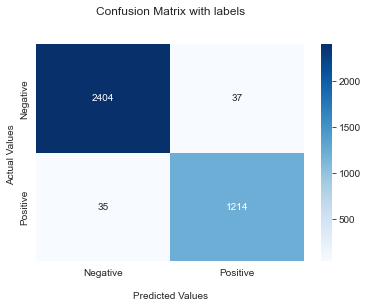


Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2441
           1       0.97      0.97      0.97      1249

    accuracy                           0.98      3690
   macro avg       0.98      0.98      0.98      3690
weighted avg       0.98      0.98      0.98      3690



In [12]:
y_pred = sgd_classifier.predict(x_test_transformed)

print("Confusion Matrix")
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

ax = sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negative','Positive'])
ax.yaxis.set_ticklabels(['Negative','Positive'])

## Display the visualization of the Confusion Matrix.
plt.show()

# Classification Report
print("\nClassification Report")
report = classification_report(y_test, y_pred)
print(report)

In [13]:
X_test['is_misinfo_pred'] = y_pred
X_test['is_misinfo_true'] = y_test
X_test.loc[~(X_test['is_misinfo_pred'] == X_test['is_misinfo_true'])]

,id,text,is_misinfo_pred,is_misinfo_true
9524,1389655905055100931,I just saw a woman on tv that had the first sh...,0,1
8236,1387148412336869382,Doctors calling the vaccine a bioweapond!\n\n...,0,1
6725,1388281248557125633,This Tweet from @chokokoyo has been withheld i...,1,0
4643,1359217309299007489,A medical doctor just told my parents that he ...,1,0
3124,1345765074657542144,Can someone please impregnate me before they f...,0,1
...,...,...,...,...
379,1344293096532676609,"#econtwitter : discussions on papers, runs, R...",1,0
1748,1346916513719189509,ICYMI: It’s dangerous to introduce COVID-19 va...,0,1
8201,1387166410321899526,Yes. This is a real story. The COVID vaccines ...,1,0
1995,1346889535406403587,Allergic reactions including anaphylaxis after...,0,1
